We need to do 3 things mainly:

1. Find optimal profit for presets of overbooking

2. Add in option for no-booking. (hint: set overbooking to a high number)

3. Add seasonality (updating probabilities in our U-matrix)

4. Simulation (forward programming)

5. Report Analysis

### Question 1: Expected discounted profit from overbooking 5 seats

In [1]:
import numpy as np
from scipy.stats import binom

def solve_dp_modified_v2(overbook):
    # ---------------------------
    # 1. Problem Parameters
    # ---------------------------
    T = 365  # days until departure (selling opportunities)
    coach_capacity = 100  # physical coach seats
    first_capacity = 20   # physical first-class seats
    
    # Maximum coach tickets sold (physical capacity + oversell)
    C_max = coach_capacity + overbook  
    F_max = first_capacity  # first-class: no overbooking
    
    # Show-up probabilities at departure:
    p_show_coach = 0.95
    p_show_first = 0.97
    
    # Pricing options.
    # For coach tickets we now use two-element probability vectors:
    # Format: [immediate sale probability, no-sale probability]
    coach_options = {
        300: np.array([0.65, 0.35]),
        350: np.array([0.30, 0.70])
    }
    
    # For first-class tickets:
    first_options = {
        425: np.array([0.08, 0.92]),
        500: np.array([0.04, 0.96])
    }
    
    # When first-class is full, coach sale probability is boosted by:
    p_increase = 0.03

    # Daily discount factor (annual rate of 17%)
    beta = 1.0 / (1.0 + 0.17 / 365)
    
    # ---------------------------
    # 2. Terminal Cost Calculation
    # ---------------------------
    terminal_value = np.zeros((C_max + 1, F_max + 1))
    for c in range(C_max + 1):
        for f in range(F_max + 1):
            expected_cost = 0.0
            for i in range(c + 1):
                p_i = binom.pmf(i, c, p_show_coach)
                for j in range(f + 1):
                    p_j = binom.pmf(j, f, p_show_first)
                    if i <= coach_capacity:
                        cost = 0
                    else:
                        extra = i - coach_capacity
                        available_first = max(first_capacity - j, 0)
                        bumped_up = min(extra, available_first)
                        bumped_off = extra - bumped_up
                        cost = 50 * bumped_up + 425 * bumped_off
                    expected_cost += p_i * p_j * cost
            terminal_value[c, f] = -expected_cost  # cost reduces profit
    
    # ---------------------------
    # 3. Dynamic Programming Setup
    # ---------------------------
    # DP[t, c, f] is the optimal expected discounted profit with t days remaining.
    # Here, we index time such that t=0 is the terminal stage (departure day).
    DP = np.full((T + 1, C_max + 1, F_max + 1), -np.inf)
    policy = np.empty((T + 1, C_max + 1, F_max + 1), dtype=object)
    
    # Terminal condition: at t = 0, profit equals terminal value.
    for c in range(C_max + 1):
        for f in range(F_max + 1):
            DP[0, c, f] = terminal_value[c, f]
    
    # -------------------------------
    # 4. Backward Induction Recursion 
    # --------------------------------
    # Loop backwards over time: from 1 day remaining to T days remaining.
    for t in range(1, T + 1):
        for c in range(C_max + 1):
            for f in range(F_max + 1):
                best_value = -np.inf
                
                # Case A: Both classes full: no sales possible.
                if (c == C_max) and (f == F_max):
                    best_value = beta * DP[t - 1, c, f]
                
                # Case B: Coach is full (c == C_max) but first-class is not.
                elif c == C_max:
                    for fp, fp_vec in first_options.items():
                        # Only first-class sale can occur.
                        # Expected immediate revenue: sale occurs with probability fp_vec[0], and no sale with fp_vec[1].
                        Exp_rev = fp * fp_vec[0]
                        # Expected future value: if sale then state moves to f+1, else remains.
                        if f < F_max:
                            Exp_future = fp_vec[0] * DP[t - 1, c, f + 1] + fp_vec[1] * DP[t - 1, c, f]
                        else:
                            Exp_future = DP[t - 1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value
                            
                # Case C: First-class is full (f == F_max) but coach is not.
                elif f == F_max:
                    for cp, cp_vec in coach_options.items():
                        # Boost immediate sale probability by p_increase.
                        cp_vec_eff = np.array([min(cp_vec[0] + p_increase, 1.0), 1 - min(cp_vec[0] + p_increase, 1.0)])
                        Exp_rev = cp * cp_vec_eff[0]
                        if c < C_max:
                            Exp_future = cp_vec_eff[0] * DP[t - 1, c + 1, f] + cp_vec_eff[1] * DP[t - 1, c, f]
                        else:
                            Exp_future = DP[t - 1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value 
                            
                # Case D: Neither class is full.
                else:
                    # We loop over all combinations of coach and first-class prices.
                    for cp, cp_vec in coach_options.items():
                        for fp, fp_vec in first_options.items():
                            # Four possible outcomes based on the two-element probability vectors.
                            # Outcome 1: Both sales occur.
                            prob_both = cp_vec[0] * fp_vec[0]
                            rev_both = cp + fp
                            val_both = DP[t - 1, c + 1, f + 1] if (c + 1 <= C_max and f + 1 <= F_max) else 0
                            
                            # Outcome 2: Only coach sale.
                            prob_coach_only = cp_vec[0] * fp_vec[1]
                            rev_coach = cp
                            val_coach = DP[t - 1, c + 1, f] if (c + 1 <= C_max) else 0
                            
                            # Outcome 3: Only first-class sale.
                            prob_first_only = cp_vec[1] * fp_vec[0]
                            rev_first = fp
                            val_first = DP[t - 1, c, f + 1] if (f + 1 <= F_max) else 0
                            
                            # Outcome 4: No sale.
                            prob_none = cp_vec[1] * fp_vec[1]
                            rev_none = 0
                            val_none = DP[t - 1, c, f]
                            
                            Exp_rev = (rev_both * prob_both + rev_coach * prob_coach_only + rev_first * prob_first_only + rev_none * prob_none)         
                            Exp_future = (val_both * prob_both + val_coach * prob_coach_only + val_first * prob_first_only + val_none * prob_none)            
                            exp_value = Exp_rev + beta * Exp_future
                            
                            if exp_value > best_value:
                                best_value = exp_value
                                
                DP[t, c, f] = best_value                
                
    optimal_profit = DP[T, 0, 0]
    return optimal_profit


overbook = 5
profit = solve_dp_modified_v2(overbook)
print("Overbooking by {} seats: Optimal expected discounted profit = ${:.2f}".format(overbook, profit))

Overbooking by 5 seats: Optimal expected discounted profit = $41886.16


### Question 2: Finding best policy from preset of overbookings

Overbooking by 5 seats: Optimal expected discounted profit = $41886.16
Overbooking by 6 seats: Optimal expected discounted profit = $42011.22
Overbooking by 7 seats: Optimal expected discounted profit = $42085.54
Overbooking by 8 seats: Optimal expected discounted profit = $42122.17
Overbooking by 9 seats: Optimal expected discounted profit = $42134.62
Overbooking by 10 seats: Optimal expected discounted profit = $42132.90
Overbooking by 11 seats: Optimal expected discounted profit = $42123.67
Overbooking by 12 seats: Optimal expected discounted profit = $42111.03
Overbooking by 13 seats: Optimal expected discounted profit = $42097.42
Overbooking by 14 seats: Optimal expected discounted profit = $42084.11
Overbooking by 15 seats: Optimal expected discounted profit = $42071.74


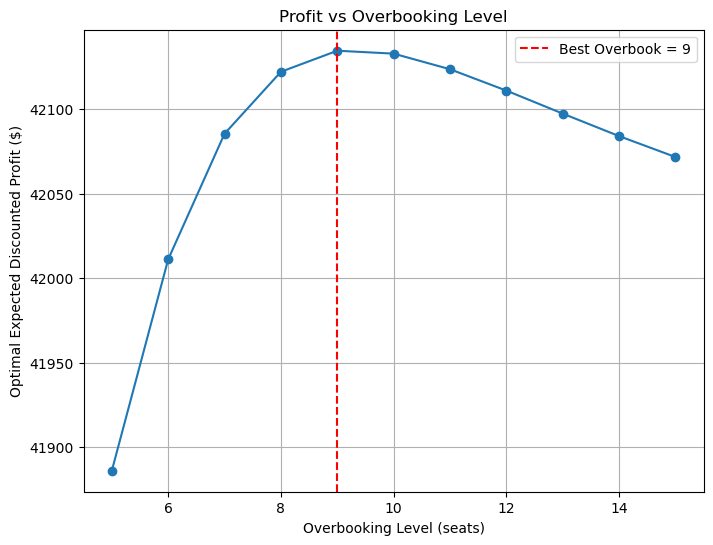


Optimal Policy: Overbooking by 9 seats yields the highest profit of $42134.62.


In [2]:
import matplotlib.pyplot as plt

overbooks = list(range(5, 16))
profits = []
for overbook in overbooks:
    profit = solve_dp_modified_v2(overbook)
    profits.append(profit)
    print("Overbooking by {} seats: Optimal expected discounted profit = ${:.2f}".format(overbook, profit))

# --- Find best overbooking level ---
best_idx = np.argmax(profits)
best_overbook = overbooks[best_idx]
best_profit = profits[best_idx]

# --- Plot the results ---
plt.figure(figsize=(8,6))
plt.plot(overbooks, profits, marker='o')
plt.xlabel("Overbooking Level (seats)")
plt.ylabel("Optimal Expected Discounted Profit ($)")
plt.title("Profit vs Overbooking Level")
plt.grid(True)
plt.axvline(best_overbook, color='r', linestyle='--', label=f"Best Overbook = {best_overbook}")
plt.legend()
plt.show()

# --- Print the best policy ---
print(f"\nOptimal Policy: Overbooking by {best_overbook} seats yields the highest profit of ${best_profit:.2f}.")

### Question 3: Giving flexibility of a no sale policy 

In [3]:
import numpy as np
from scipy.stats import binom

def solve_dp_modified_v2_with_no_sale(overbook):
    # ---------------------------
    # 1. Problem Parameters
    # ---------------------------
    T = 365                           # days until departure
    coach_capacity = 100              # physical coach seats
    first_capacity = 20               # physical first-class seats
    
    # Maximum coach tickets sold (physical capacity + oversell)
    C_max = coach_capacity + overbook  
    F_max = first_capacity            # first-class: no overbooking
    
    # Show-up probabilities at departure:
    p_show_coach = 0.95
    p_show_first = 0.97
    
    # Pricing options for coach tickets now include a no-sale option.
    # Each entry: key -> (price, [sale probability, no-sale probability])
    coach_options = {
        'no_sale': (0, np.array([0.0, 1.0])),
        300: (300, np.array([0.65, 0.35])),
        350: (350, np.array([0.30, 0.70]))
    }
    
    # Pricing options for first-class tickets (remain two options)
    first_options = {
        425: np.array([0.08, 0.92]),
        500: np.array([0.04, 0.96])
    }
    
    # When first-class is full, boost coach sale probability by:
    p_increase = 0.03

    # Daily discount factor (annual rate of 17%)
    beta = 1.0 / (1.0 + 0.17 / 365)
    
    # ---------------------------
    # 2. Terminal Cost Calculation
    # ---------------------------
    terminal_value = np.zeros((C_max + 1, F_max + 1))
    for c in range(C_max + 1):
        for f in range(F_max + 1):
            expected_cost = 0.0
            for i in range(c + 1):
                p_i = binom.pmf(i, c, p_show_coach)
                for j in range(f + 1):
                    p_j = binom.pmf(j, f, p_show_first)
                    if i <= coach_capacity:
                        cost = 0
                    else:
                        extra = i - coach_capacity
                        available_first = max(first_capacity - j, 0)
                        bumped_up = min(extra, available_first)
                        bumped_off = extra - bumped_up
                        cost = 50 * bumped_up + 425 * bumped_off
                    expected_cost += p_i * p_j * cost
            terminal_value[c, f] = -expected_cost  # cost reduces profit
    
    # ---------------------------
    # 3. Dynamic Programming Setup
    # ---------------------------
    # DP[t, c, f]: optimal expected discounted profit with t days remaining,
    # having sold c coach and f first-class tickets.
    DP = np.full((T + 1, C_max + 1, F_max + 1), -np.inf)
    policy = np.empty((T + 1, C_max + 1, F_max + 1), dtype=object)
    
    # Terminal condition: at t = 0, profit equals terminal value.
    for c in range(C_max + 1):
        for f in range(F_max + 1):
            DP[0, c, f] = terminal_value[c, f]
    
    # ---------------------------
    # 4. Backward Induction Recursion with No-Sale Option
    # ---------------------------
    for t in range(1, T + 1):
        for c in range(C_max + 1):
            for f in range(F_max + 1):
                best_value = -np.inf
                
                # Case A: Both classes full: no further sales possible.
                if (c == C_max) and (f == F_max):
                    best_value = beta * DP[t - 1, c, f]
                
                # Case B: Coach is full (c == C_max) but first-class is not.
                elif c == C_max:
                    for fp, fp_vec in first_options.items():
                        Exp_rev = fp * fp_vec[0]
                        if f < F_max:
                            Exp_future = fp_vec[0] * DP[t - 1, c, f + 1] + fp_vec[1] * DP[t - 1, c, f]
                        else:
                            Exp_future = DP[t - 1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value
                            
                # Case C: First-class is full (f == F_max) but coach is not.
                elif f == F_max:
                    for cp_key, (cp, cp_vec) in coach_options.items():
                        if cp_key != 'no_sale':
                            # Boost sale probability when first-class is full.
                            cp_eff = np.array([min(cp_vec[0] + p_increase, 1.0),
                                               1 - min(cp_vec[0] + p_increase, 1.0)])
                        else:
                            cp_eff = cp_vec  # no_sale remains [0.0, 1.0]
                        Exp_rev = cp * cp_eff[0]
                        # For no_sale, state remains unchanged; otherwise, a sale increases c.
                        if cp_key != 'no_sale' and c < C_max:
                            Exp_future = cp_eff[0] * DP[t - 1, c + 1, f] + cp_eff[1] * DP[t - 1, c, f]
                        else:
                            Exp_future = DP[t - 1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value 
                            
                # Case D: Neither class is full: both pricing decisions available.
                else:
                    for cp_key, (cp, cp_vec) in coach_options.items():
                        for fp, fp_vec in first_options.items():
                            if cp_key == 'no_sale':
                                # With no_sale, no coach ticket is sold.
                                # Only first-class outcomes matter:
                                prob_first_only = cp_vec[1] * fp_vec[0]  # state → (c, f+1)
                                rev_first = fp
                                val_first = DP[t - 1, c, f + 1] if (f + 1 <= F_max) else 0
                                prob_none = cp_vec[1] * fp_vec[1]         # state remains (c, f)
                                val_none = DP[t - 1, c, f]
                                exp_rev = rev_first * prob_first_only  # no coach revenue
                                Exp_future = val_first * prob_first_only + val_none * prob_none
                                exp_value = exp_rev + beta * Exp_future
                            else:
                                # Standard outcomes with a coach sale option.
                                prob_both = cp_vec[0] * fp_vec[0]
                                rev_both = cp + fp
                                val_both = DP[t - 1, c + 1, f + 1] if (c + 1 <= C_max and f + 1 <= F_max) else 0
                                
                                prob_coach_only = cp_vec[0] * fp_vec[1]
                                rev_coach = cp
                                val_coach = DP[t - 1, c + 1, f] if (c + 1 <= C_max) else 0
                                
                                prob_first_only = cp_vec[1] * fp_vec[0]
                                rev_first = fp
                                val_first = DP[t - 1, c, f + 1] if (f + 1 <= F_max) else 0
                                
                                prob_none = cp_vec[1] * fp_vec[1]
                                val_none = DP[t - 1, c, f]
                                
                                exp_rev = (rev_both * prob_both + rev_coach * prob_coach_only + rev_first * prob_first_only)
                                Exp_future = (val_both * prob_both + val_coach * prob_coach_only + val_first * prob_first_only + val_none * prob_none)                                              
                                exp_value = exp_rev + beta * Exp_future
                            
                            if exp_value > best_value:
                                best_value = exp_value
                DP[t, c, f] = best_value
    optimal_profit = DP[T, 0, 0]
    return optimal_profit


overbook = 20
profit = solve_dp_modified_v2_with_no_sale(overbook)
print("Overbooking by {} seats: Optimal expected discounted profit = ${:.2f}".format(overbook, profit))


Overbooking by 20 seats: Optimal expected discounted profit = $42139.89


Adding flexibility of no sale policy increases the profit slightly. So we consider this as the best policy

### Question 4: Adding seasonality

In [4]:
import numpy as np
from scipy.stats import binom

def solve_dp_modified_v2_with_seasonality(overbook):
    # ---------------------------
    # 1. Problem Parameters
    # ---------------------------
    T = 365                           # Total selling days
    coach_capacity = 100              # Physical coach seats
    first_capacity = 20               # Physical first-class seats
    C_max = coach_capacity + overbook # Maximum coach tickets sold (cap + overbook)
    F_max = first_capacity            # First-class has no overbooking
    
    # Show-up probabilities at departure:
    p_show_coach = 0.95
    p_show_first = 0.97
    
    # Pricing options for coach tickets now include a no-sale option.
    # Each option: (price, [base sale probability, base no-sale probability])
    coach_options = {
        'no_sale': (0, np.array([0.0, 1.0])),
        300: (300, np.array([0.65, 0.35])),
        350: (350, np.array([0.30, 0.70]))
    }
    # Pricing options for first-class tickets:
    first_options = {
        425: np.array([0.08, 0.92]),
        500: np.array([0.04, 0.96])
    }
    p_increase = 0.03                # Boost for coach sale probability when first-class is full
    beta = 1.0 / (1.0 + 0.17 / 365)  # Daily discount factor

    # ---------------------------
    # 2. Terminal Cost Calculation
    # ---------------------------
    terminal_value = np.zeros((C_max + 1, F_max + 1))
    for c in range(C_max + 1):
        for f in range(F_max + 1):
            expected_cost = 0.0
            for i in range(c + 1):
                p_i = binom.pmf(i, c, p_show_coach)
                for j in range(f + 1):
                    p_j = binom.pmf(j, f, p_show_first)
                    if i <= coach_capacity:
                        cost = 0
                    else:
                        extra = i - coach_capacity
                        available_first = max(first_capacity - j, 0)
                        bumped_up = min(extra, available_first)
                        bumped_off = extra - bumped_up
                        cost = 50 * bumped_up + 425 * bumped_off
                    expected_cost += p_i * p_j * cost
            terminal_value[c, f] = -expected_cost  # Terminal value is negative cost
    
    # ---------------------------
    # 3. Dynamic Programming Setup
    # ---------------------------
    DP = np.full((T + 1, C_max + 1, F_max + 1), -np.inf)
    policy = np.empty((T + 1, C_max + 1, F_max + 1), dtype=object)
    for c in range(C_max + 1):
        for f in range(F_max + 1):
            DP[0, c, f] = terminal_value[c, f]
    
    # ---------------------------
    # 4. Backward Induction with Seasonality
    # ---------------------------
    # In our recursion, t represents days remaining.
    # We compute the "calendar" day as: day = T - t + 1.
    for t in range(1, T + 1):
        day = T - t + 1
        season_factor = 0.75 + day / 730.0
        for c in range(C_max + 1):
            for f in range(F_max + 1):
                best_value = -np.inf
                # Case A: Both classes full -> no sale possible.
                if (c == C_max) and (f == F_max):
                    best_value = beta * DP[t - 1, c, f]
                # Case B: Coach full -> Only first-class decision.
                elif c == C_max:
                    for fp, fp_vec in first_options.items():
                        fp_sale = min(fp_vec[0] * season_factor, 1.0)
                        fp_no_sale = 1 - fp_sale
                        Exp_rev = fp * fp_sale
                        Exp_future = (fp_sale * DP[t - 1, c, f + 1] + fp_no_sale * DP[t - 1, c, f]) if f < F_max else DP[t - 1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value
                # Case C: First-class full -> Only coach decision.
                elif f == F_max:
                    for cp_key, (cp, cp_vec) in coach_options.items():
                        if cp_key != 'no_sale':
                            cp_sale = min((cp_vec[0] + p_increase) * season_factor, 1.0)
                            cp_no_sale = 1 - cp_sale
                        else:
                            cp_sale = cp_vec[0]  # 0
                            cp_no_sale = cp_vec[1]  # 1
                        Exp_rev = cp * cp_sale
                        Exp_future = (cp_sale * DP[t - 1, c + 1, f] + cp_no_sale * DP[t - 1, c, f]) if c < C_max and cp_key != 'no_sale' else DP[t - 1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value 
                # Case D: Neither class full -> both pricing decisions available.
                else:
                    for cp_key, (cp, cp_vec) in coach_options.items():
                        if cp_key != 'no_sale':
                            cp_sale = min(cp_vec[0] * season_factor, 1.0)
                            cp_no_sale = 1 - cp_sale
                        else:
                            cp_sale = cp_vec[0]   # 0
                            cp_no_sale = cp_vec[1]  # 1
                        for fp, fp_vec in first_options.items():
                            fp_sale = min(fp_vec[0] * season_factor, 1.0)
                            fp_no_sale = 1 - fp_sale
                            if cp_key == 'no_sale':
                                # No coach sale: state does not change for coach; only first-class outcomes.
                                prob_first_only = cp_no_sale * fp_sale  # sale in first-class
                                rev_first = fp
                                val_first = DP[t - 1, c, f + 1] if (f + 1 <= F_max) else 0
                                prob_none = cp_no_sale * fp_no_sale
                                val_none = DP[t - 1, c, f]
                                exp_rev = rev_first * prob_first_only
                                Exp_future = val_first * prob_first_only + val_none * prob_none
                                exp_value = exp_rev + beta * Exp_future
                            else:
                                # Four outcomes: both, coach only, first-only, none.
                                prob_both = cp_sale * fp_sale
                                rev_both = cp + fp
                                val_both = DP[t - 1, c + 1, f + 1] if (c + 1 <= C_max and f + 1 <= F_max) else 0
                                prob_coach_only = cp_sale * fp_no_sale
                                rev_coach = cp
                                val_coach = DP[t - 1, c + 1, f] if (c + 1 <= C_max) else 0
                                prob_first_only = cp_no_sale * fp_sale
                                rev_first = fp
                                val_first = DP[t - 1, c, f + 1] if (f + 1 <= F_max) else 0
                                prob_none = cp_no_sale * fp_no_sale
                                val_none = DP[t - 1, c, f]
                                exp_rev = rev_both * prob_both + rev_coach * prob_coach_only + rev_first * prob_first_only
                                Exp_future = val_both * prob_both + val_coach * prob_coach_only + val_first * prob_first_only + val_none * prob_none
                                exp_value = exp_rev + beta * Exp_future
                            if exp_value > best_value:
                                best_value = exp_value
                DP[t, c, f] = best_value
    return DP[T, 0, 0]


overbook = 20
profit = solve_dp_modified_v2_with_seasonality(overbook)
print("Overbooking by {} seats: Optimal expected discounted profit = ${:.2f}".format(overbook, profit))


Overbooking by 20 seats: Optimal expected discounted profit = $41841.11


### Question 5: Simulation

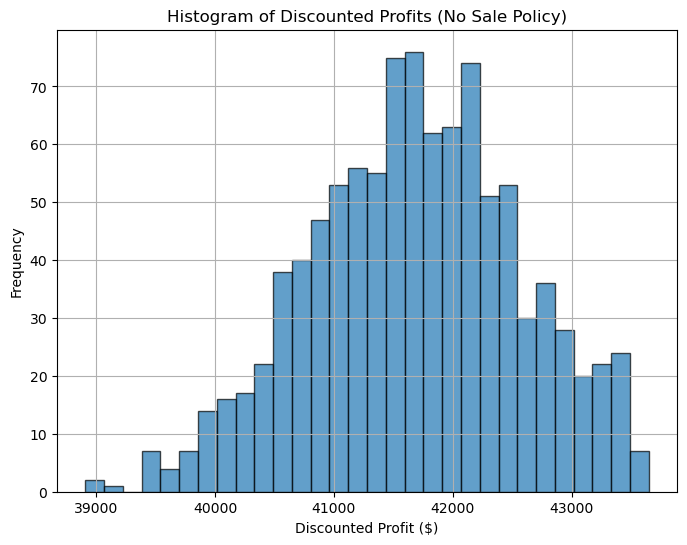

Simulation Results (No Sale Policy):
Simulations run: 1000
Average Discounted Profit: $41683.30
Profit Volatility (Std Dev): $885.21
Coach Overbooking Frequency: 82.70%
Average Overbooking Cost: $1040.38
Average Bumped Up Passengers: 0.77
Average Bumped Off Passengers: 2.36


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# ------------------------------------------------------------------
# Step 1. Compute the DP and record the optimal decision (policy)
# for the "with no sale" policy (similar to Q3)
# ------------------------------------------------------------------

def compute_dp_no_sale(overbook):
    # ---------------------------
    # Problem Parameters
    # ---------------------------
    T = 365                           # total selling days
    coach_capacity = 100              # physical coach seats
    first_capacity = 20               # physical first-class seats
    C_max = coach_capacity + overbook # max coach tickets sold (capacity + overbook)
    F_max = first_capacity            # first-class: no overbooking
    
    # Show-up probabilities (at departure)
    p_show_coach = 0.95
    p_show_first = 0.97
    
    # Pricing options for coach (with a "no_sale" option)
    # Each entry: key -> (price, [sale probability, no-sale probability])
    coach_options = {
        'no_sale': (0, np.array([0.0, 1.0])),
        300: (300, np.array([0.65, 0.35])),
        350: (350, np.array([0.30, 0.70]))
    }
    
    # Pricing options for first-class tickets
    first_options = {
        425: np.array([0.08, 0.92]),
        500: np.array([0.04, 0.96])
    }
    
    p_increase = 0.03                # boost for coach sale when first-class is full
    beta = 1.0 / (1.0 + 0.17/365)      # daily discount factor

    # ---------------------------
    # Allocate DP and policy arrays
    # DP[t, c, f]: optimal expected discounted profit with t days remaining,
    # having sold c coach and f first-class tickets.
    # policy[t, c, f]: the optimal decision (to be used for simulation)
    # For policy we store a tuple:
    #   ("none", None, None): no sale possible,
    #   ("first", None, fp): only first-class decision, price = fp,
    #   ("coach", cp_key, None): only coach decision, option key = cp_key,
    #   ("both", cp_key, fp): both decisions available.
    # ---------------------------
    DP = np.full((T+1, C_max+1, F_max+1), -np.inf)
    policy = np.empty((T+1, C_max+1, F_max+1), dtype=object)
    
    # ---------------------------
    # Terminal Cost: at departure (t=0)
    # ---------------------------
    terminal_value = np.zeros((C_max+1, F_max+1))
    for c in range(C_max+1):
        for f in range(F_max+1):
            expected_cost = 0.0
            for i in range(c+1):
                p_i = binom.pmf(i, c, p_show_coach)
                for j in range(f+1):
                    p_j = binom.pmf(j, f, p_show_first)
                    if i <= coach_capacity:
                        cost = 0
                    else:
                        extra = i - coach_capacity
                        available_first = max(first_capacity - j, 0)
                        bumped_up = min(extra, available_first)
                        bumped_off = extra - bumped_up
                        cost = 50 * bumped_up + 425 * bumped_off
                    expected_cost += p_i * p_j * cost
            terminal_value[c, f] = -expected_cost  # terminal value is negative cost
            DP[0, c, f] = terminal_value[c, f]
            policy[0, c, f] = None

    # ---------------------------
    # Backward Induction: t=1,...,T
    # ---------------------------
    for t in range(1, T+1):
        for c in range(C_max+1):
            for f in range(F_max+1):
                best_value = -np.inf
                best_action = None
                
                # Case A: Both classes full: no sale possible.
                if (c == C_max) and (f == F_max):
                    best_value = beta * DP[t-1, c, f]
                    best_action = ("none", None, None)
                    
                # Case B: Coach is full, so only first-class decision available.
                elif c == C_max:
                    for fp, fp_vec in first_options.items():
                        Exp_rev = fp * fp_vec[0]
                        if f < F_max:
                            Exp_future = fp_vec[0] * DP[t-1, c, f+1] + fp_vec[1] * DP[t-1, c, f]
                        else:
                            Exp_future = DP[t-1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value
                            best_action = ("first", None, fp)
                            
                # Case C: First-class is full, so only coach decision available.
                elif f == F_max:
                    for cp_key, (cp, cp_vec) in coach_options.items():
                        if cp_key != 'no_sale':
                            cp_eff = np.array([min(cp_vec[0] + p_increase, 1.0), 1 - min(cp_vec[0] + p_increase, 1.0)])
                        else:
                            cp_eff = cp_vec
                        Exp_rev = cp * cp_eff[0]
                        if c < C_max and cp_key != 'no_sale':
                            Exp_future = cp_eff[0] * DP[t-1, c+1, f] + cp_eff[1] * DP[t-1, c, f]
                        else:
                            Exp_future = DP[t-1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value
                            best_action = ("coach", cp_key, None)
                            
                # Case D: Neither class is full: both decisions available.
                else:
                    for cp_key, (cp, cp_vec) in coach_options.items():
                        for fp, fp_vec in first_options.items():
                            if cp_key == 'no_sale':
                                # No coach sale option: only first-class outcome matters.
                                prob_first_only = cp_vec[1] * fp_vec[0]
                                rev_first = fp
                                val_first = DP[t-1, c, f+1] if (f+1 <= F_max) else 0
                                prob_none = cp_vec[1] * fp_vec[1]
                                val_none = DP[t-1, c, f]
                                exp_rev = rev_first * prob_first_only
                                Exp_future = val_first * prob_first_only + val_none * prob_none
                                exp_value = exp_rev + beta * Exp_future
                                action = ("both", cp_key, fp)
                            else:
                                # Standard coach option.
                                prob_both = cp_vec[0] * fp_vec[0]
                                rev_both = cp + fp
                                val_both = DP[t-1, c+1, f+1] if (c+1 <= C_max and f+1 <= F_max) else 0
                                prob_coach_only = cp_vec[0] * fp_vec[1]
                                rev_coach = cp
                                val_coach = DP[t-1, c+1, f] if (c+1 <= C_max) else 0
                                prob_first_only = cp_vec[1] * fp_vec[0]
                                rev_first = fp
                                val_first = DP[t-1, c, f+1] if (f+1 <= F_max) else 0
                                prob_none = cp_vec[1] * fp_vec[1]
                                val_none = DP[t-1, c, f]
                                exp_rev = rev_both * prob_both + rev_coach * prob_coach_only + rev_first * prob_first_only
                                Exp_future = (val_both * prob_both + val_coach * prob_coach_only +
                                              val_first * prob_first_only + val_none * prob_none)
                                exp_value = exp_rev + beta * Exp_future
                                action = ("both", cp_key, fp)
                            if exp_value > best_value:
                                best_value = exp_value
                                best_action = action
                DP[t, c, f] = best_value
                policy[t, c, f] = best_action
    return (DP, policy, beta, T, C_max, F_max, 
            coach_options, first_options, p_increase, coach_capacity, first_capacity, 
            p_show_coach, p_show_first)

# ------------------------------------------------------------------
# Step 2. Simulation function using the computed DP policy
# ------------------------------------------------------------------

def simulate_forward_no_sale(DP, policy, beta, T, C_max, F_max, 
                             coach_options, first_options, p_increase, 
                             coach_capacity, first_capacity, 
                             p_show_coach, p_show_first, num_simulations=1000):
    profits = []
    overbooked_count = 0
    total_bumped_off = 0
    total_bumped_up = 0
    total_overbooking_cost = 0
    results = []
    
    for sim in range(num_simulations):
        t = T
        c = 0  # coach tickets sold
        f = 0  # first-class tickets sold
        discounted_revenue = 0.0
        
        # Simulate each selling day
        for day in range(1, T+1):
            decision = policy[t, c, f]
            revenue_day = 0
            
            if decision is None or decision[0] == "none":
                # No sale possible.
                pass
            elif decision[0] == "first":
                # Only first-class decision available.
                fp = decision[2]
                fp_vec = first_options[fp]
                if np.random.rand() < fp_vec[0]:
                    revenue_day += fp
                    f = min(f + 1, F_max)
            elif decision[0] == "coach":
                # Only coach decision available.
                cp_key = decision[1]
                cp, cp_vec = coach_options[cp_key]
                if cp_key == 'no_sale':
                    pass
                else:
                    # When first-class is full, adjust sale probability.
                    if f == F_max:
                        cp_sale_prob = min(cp_vec[0] + p_increase, 1.0)
                    else:
                        cp_sale_prob = cp_vec[0]
                    if np.random.rand() < cp_sale_prob:
                        revenue_day += cp
                        c = min(c + 1, C_max)
            elif decision[0] == "both":
                cp_key = decision[1]
                fp = decision[2]
                cp, cp_vec = coach_options[cp_key]
                fp_vec = first_options[fp]
                # Adjust coach sale probability if first-class is full.
                if f == F_max and cp_key != 'no_sale':
                    cp_sale_prob = min(cp_vec[0] + p_increase, 1.0)
                elif cp_key != 'no_sale':
                    cp_sale_prob = cp_vec[0]
                else:
                    cp_sale_prob = cp_vec[0]  # 0 for no_sale
                
                # Outcome probabilities (for both available):
                # Four outcomes: both sale, coach only, first only, none.
                r = np.random.rand()
                if r < cp_sale_prob * fp_vec[0]:
                    revenue_day += (cp + fp)
                    c = min(c + 1, C_max)
                    f = min(f + 1, F_max)
                elif r < cp_sale_prob * fp_vec[0] + cp_sale_prob * fp_vec[1]:
                    revenue_day += cp
                    c = min(c + 1, C_max)
                elif r < cp_sale_prob * fp_vec[0] + cp_sale_prob * fp_vec[1] + (1 - cp_sale_prob) * fp_vec[0]:
                    revenue_day += fp
                    f = min(f + 1, F_max)
                else:
                    # no sale occurs.
                    pass
            # Discount today's revenue. (Revenue on day 'day' is discounted by beta^(T-day))
            discount = beta ** (T - day)
            discounted_revenue += revenue_day * discount
            t -= 1  # one day passes
            
        # End-of-period: simulate passenger show-ups.
        coach_show = np.random.binomial(c, p_show_coach)
        first_show = np.random.binomial(f, p_show_first)
        # Compute overbooking cost for coach.
        if coach_show <= coach_capacity:
            over_cost = 0
            bumped_up = 0
            bumped_off = 0
        else:
            extra = coach_show - coach_capacity
            available_first = max(first_capacity - first_show, 0)
            bumped_up = min(extra, available_first)
            bumped_off = extra - bumped_up
            over_cost = 50 * bumped_up + 425 * bumped_off
            
        total_profit = discounted_revenue - over_cost
        profits.append(total_profit)
        
        if coach_show > coach_capacity:
            overbooked_count += 1
        total_bumped_off += bumped_off
        total_bumped_up += bumped_up
        total_overbooking_cost += over_cost
        
        results.append({
            "coach_sold": c,
            "first_sold": f,
            "coach_show": coach_show,
            "first_show": first_show,
            "revenue": discounted_revenue,
            "over_cost": over_cost,
            "total_profit": total_profit
        })
        
    # Aggregate simulation metrics.
    avg_profit = np.mean(profits)
    std_profit = np.std(profits)
    overbook_freq = overbooked_count / num_simulations
    avg_overbooking_cost = total_overbooking_cost / num_simulations
    avg_bumped_up = total_bumped_up / num_simulations
    avg_bumped_off = total_bumped_off / num_simulations
    
    # Plot a histogram of discounted profits.
    plt.figure(figsize=(8,6))
    plt.hist(profits, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Discounted Profit ($)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Discounted Profits (No Sale Policy)")
    plt.grid(True)
    plt.show()
    
    # Print simulation summary.
    print("Simulation Results (No Sale Policy):")
    print(f"Simulations run: {num_simulations}")
    print(f"Average Discounted Profit: ${avg_profit:.2f}")
    print(f"Profit Volatility (Std Dev): ${std_profit:.2f}")
    print(f"Coach Overbooking Frequency: {overbook_freq*100:.2f}%")
    print(f"Average Overbooking Cost: ${avg_overbooking_cost:.2f}")
    print(f"Average Bumped Up Passengers: {avg_bumped_up:.2f}")
    print(f"Average Bumped Off Passengers: {avg_bumped_off:.2f}")
    
    return results

# ------------------------------------------------------------------
# Step 3. Run the DP computation and then simulate forward many times.
# For example, using an overbooking limit of 20 seats.
# ------------------------------------------------------------------

overbook = 20
num_simulations = 1000

# Compute the DP and policy for the "no sale" policy.
(DP, policy, beta, T, C_max, F_max, 
 coach_options, first_options, p_increase, 
 coach_capacity, first_capacity, 
 p_show_coach, p_show_first) = compute_dp_no_sale(overbook)

# --- Policy A: No Sale Option ---

# Compute the DP and policy for the no-sale policy.
(DP_no_sale, policy_no_sale, beta, T, C_max, F_max, 
 coach_options, first_options, p_increase, coach_capacity, first_capacity, 
 p_show_coach, p_show_first) = compute_dp_no_sale(overbook)

# Run the forward simulation using the computed optimal policy.
simulation_results_A = simulate_forward_no_sale(DP_no_sale, policy_no_sale, beta, T, C_max, F_max, 
                                                coach_options, first_options, p_increase, 
                                                coach_capacity, first_capacity, 
                                                p_show_coach, p_show_first, num_simulations)

In [5]:
def simulate_forward_seasonality(DP, policy, beta, T, C_max, F_max, 
                                 coach_options, first_options, p_increase, 
                                 coach_capacity, first_capacity, 
                                 p_show_coach, p_show_first, num_simulations=1000):
    """
    Simulate the forward selling process for the seasonality policy.
    Each day, the sale probabilities are adjusted by a seasonality factor:
        season_factor = 0.75 + (day / 730)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    profits = []
    overbooked_count = 0
    total_bumped_off = 0
    total_bumped_up = 0
    total_overbooking_cost = 0
    results = []
    
    for sim in range(num_simulations):
        t = T
        c = 0  # Number of coach tickets sold
        f = 0  # Number of first-class tickets sold
        discounted_revenue = 0.0
        
        # Simulate each selling day.
        for day in range(1, T + 1):
            # Seasonality factor increases demand as the flight date approaches.
            season_factor = 0.75 + day / 730.0
            decision = policy[t, c, f]
            revenue_day = 0
            
            if decision is None or decision[0] == "none":
                # No sale possible.
                pass
            elif decision[0] == "first":
                # Only first-class decision available.
                fp = decision[2]
                fp_vec = first_options[fp]
                # Adjust probability with seasonality (cap at 1.0).
                fp_sale_prob = min(fp_vec[0] * season_factor, 1.0)
                if np.random.rand() < fp_sale_prob:
                    revenue_day += fp
                    f = min(f + 1, F_max)
            elif decision[0] == "coach":
                # Only coach decision available.
                cp_key = decision[1]
                cp, cp_vec = coach_options[cp_key]
                if cp_key == 'no_sale':
                    # No sale option: do nothing.
                    pass
                else:
                    # If first-class is full, boost sale probability.
                    if f == F_max:
                        cp_sale_prob = min((cp_vec[0] + p_increase) * season_factor, 1.0)
                    else:
                        cp_sale_prob = min(cp_vec[0] * season_factor, 1.0)
                    if np.random.rand() < cp_sale_prob:
                        revenue_day += cp
                        c = min(c + 1, C_max)
            elif decision[0] == "both":
                # Both pricing decisions are available.
                cp_key = decision[1]
                fp = decision[2]
                cp, cp_vec = coach_options[cp_key]
                fp_vec = first_options[fp]
                # Adjust probabilities by seasonality.
                if cp_key != 'no_sale':
                    if f == F_max:
                        cp_sale_prob = min((cp_vec[0] + p_increase) * season_factor, 1.0)
                    else:
                        cp_sale_prob = min(cp_vec[0] * season_factor, 1.0)
                else:
                    cp_sale_prob = 0.0
                fp_sale_prob = min(fp_vec[0] * season_factor, 1.0)
                
                # Determine outcome based on combined probabilities.
                r = np.random.rand()
                if r < cp_sale_prob * fp_sale_prob:
                    revenue_day += (cp + fp)
                    c = min(c + 1, C_max)
                    f = min(f + 1, F_max)
                elif r < cp_sale_prob * fp_sale_prob + cp_sale_prob * (1 - fp_sale_prob):
                    revenue_day += cp
                    c = min(c + 1, C_max)
                elif r < cp_sale_prob * fp_sale_prob + cp_sale_prob * (1 - fp_sale_prob) + (1 - cp_sale_prob) * fp_sale_prob:
                    revenue_day += fp
                    f = min(f + 1, F_max)
                else:
                    # No sale occurs.
                    pass
            # Discount today's revenue. (Revenue on day 'day' is discounted by beta^(T-day))
            discount = beta ** (T - day)
            discounted_revenue += revenue_day * discount
            t -= 1  # Move to the next day.
        
        # At departure, simulate the show-up process using a binomial draw.
        coach_show = np.random.binomial(c, p_show_coach)
        first_show = np.random.binomial(f, p_show_first)
        # Compute overbooking cost for coach.
        if coach_show <= coach_capacity:
            over_cost = 0
            bumped_up = 0
            bumped_off = 0
        else:
            extra = coach_show - coach_capacity
            available_first = max(first_capacity - first_show, 0)
            bumped_up = min(extra, available_first)
            bumped_off = extra - bumped_up
            over_cost = 50 * bumped_up + 425 * bumped_off
            
        total_profit = discounted_revenue - over_cost
        profits.append(total_profit)
        
        if coach_show > coach_capacity:
            overbooked_count += 1
        total_bumped_off += bumped_off
        total_bumped_up += bumped_up
        total_overbooking_cost += over_cost
        
        results.append({
            "coach_sold": c,
            "first_sold": f,
            "coach_show": coach_show,
            "first_show": first_show,
            "revenue": discounted_revenue,
            "over_cost": over_cost,
            "total_profit": total_profit,
            "bumped_off": bumped_off,
            "bumped_up": bumped_up
        })
        
    # Aggregate simulation metrics.
    avg_profit = np.mean(profits)
    std_profit = np.std(profits)
    overbook_freq = overbooked_count / num_simulations
    avg_overbooking_cost = total_overbooking_cost / num_simulations
    avg_bumped_up = total_bumped_up / num_simulations
    avg_bumped_off = total_bumped_off / num_simulations
    
    # Plot a histogram of discounted profits.
    plt.figure(figsize=(8,6))
    plt.hist(profits, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Discounted Profit ($)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Discounted Profits (Seasonality Policy)")
    plt.grid(True)
    plt.show()
    
    # Print simulation summary.
    print("Simulation Results (Seasonality Policy):")
    print(f"Simulations run: {num_simulations}")
    print(f"Average Discounted Profit: ${avg_profit:.2f}")
    print(f"Profit Volatility (Std Dev): ${std_profit:.2f}")
    print(f"Coach Overbooking Frequency: {overbook_freq*100:.2f}%")
    print(f"Average Overbooking Cost: ${avg_overbooking_cost:.2f}")
    print(f"Average Bumped Up Passengers: {avg_bumped_up:.2f}")
    print(f"Average Bumped Off Passengers: {avg_bumped_off:.2f}")
    
    return results

In [7]:
def compute_dp_seasonality(overbook):
    T = 365  # selling days
    coach_capacity = 100
    first_capacity = 20
    C_max = coach_capacity + overbook
    F_max = first_capacity

    p_show_coach = 0.95
    p_show_first = 0.97

    coach_options = {
        'no_sale': (0, np.array([0.0, 1.0])),
        300: (300, np.array([0.65, 0.35])),
        350: (350, np.array([0.30, 0.70]))
    }

    first_options = {
        425: np.array([0.08, 0.92]),
        500: np.array([0.04, 0.96])
    }

    p_increase = 0.03
    beta = 1.0 / (1.0 + 0.17 / 365)

    DP = np.full((T + 1, C_max + 1, F_max + 1), -np.inf)
    policy = np.empty((T + 1, C_max + 1, F_max + 1), dtype=object)

    # Terminal cost: expected overbooking cost
    from scipy.stats import binom
    for c in range(C_max + 1):
        for f in range(F_max + 1):
            expected_cost = 0.0
            for i in range(c + 1):
                p_i = binom.pmf(i, c, p_show_coach)
                for j in range(f + 1):
                    p_j = binom.pmf(j, f, p_show_first)
                    if i <= coach_capacity:
                        cost = 0
                    else:
                        extra = i - coach_capacity
                        available_first = max(first_capacity - j, 0)
                        bumped_up = min(extra, available_first)
                        bumped_off = extra - bumped_up
                        cost = 50 * bumped_up + 425 * bumped_off
                    expected_cost += p_i * p_j * cost
            DP[0, c, f] = -expected_cost
            policy[0, c, f] = None

    # Backward induction
    for t in range(1, T + 1):
        day = T - t + 1
        season_factor = 0.75 + day / 730.0
        for c in range(C_max + 1):
            for f in range(F_max + 1):
                best_value = -np.inf
                best_action = None

                if c == C_max and f == F_max:
                    best_value = beta * DP[t - 1, c, f]
                    best_action = ("none", None, None)

                elif c == C_max:
                    for fp, fp_vec in first_options.items():
                        fp_sale = min(fp_vec[0] * season_factor, 1.0)
                        fp_no = 1 - fp_sale
                        Exp_rev = fp * fp_sale
                        if f < F_max:
                            Exp_future = fp_sale * DP[t - 1, c, f + 1] + fp_no * DP[t - 1, c, f]
                        else:
                            Exp_future = DP[t - 1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value
                            best_action = ("first", None, fp)

                elif f == F_max:
                    for cp_key, (cp, cp_vec) in coach_options.items():
                        if cp_key != 'no_sale':
                            cp_sale = min((cp_vec[0] + p_increase) * season_factor, 1.0)
                        else:
                            cp_sale = cp_vec[0]
                        cp_no = 1 - cp_sale
                        Exp_rev = cp * cp_sale
                        if cp_key != 'no_sale' and c < C_max:
                            Exp_future = cp_sale * DP[t - 1, c + 1, f] + cp_no * DP[t - 1, c, f]
                        else:
                            Exp_future = DP[t - 1, c, f]
                        exp_value = Exp_rev + beta * Exp_future
                        if exp_value > best_value:
                            best_value = exp_value
                            best_action = ("coach", cp_key, None)

                else:
                    for cp_key, (cp, cp_vec) in coach_options.items():
                        if cp_key != 'no_sale':
                            cp_sale = min(cp_vec[0] * season_factor, 1.0)
                        else:
                            cp_sale = 0.0
                        cp_no = 1 - cp_sale
                        for fp, fp_vec in first_options.items():
                            fp_sale = min(fp_vec[0] * season_factor, 1.0)
                            fp_no = 1 - fp_sale

                            if cp_key == 'no_sale':
                                prob_first_only = cp_no * fp_sale
                                val_first = DP[t - 1, c, f + 1] if (f + 1 <= F_max) else 0
                                prob_none = cp_no * fp_no
                                val_none = DP[t - 1, c, f]
                                exp_rev = fp * prob_first_only
                                Exp_future = prob_first_only * val_first + prob_none * val_none
                            else:
                                prob_both = cp_sale * fp_sale
                                val_both = DP[t - 1, c + 1, f + 1] if (c + 1 <= C_max and f + 1 <= F_max) else 0
                                prob_coach = cp_sale * fp_no
                                val_coach = DP[t - 1, c + 1, f] if (c + 1 <= C_max) else 0
                                prob_first = cp_no * fp_sale
                                val_first = DP[t - 1, c, f + 1] if (f + 1 <= F_max) else 0
                                prob_none = cp_no * fp_no
                                val_none = DP[t - 1, c, f]
                                exp_rev = cp * prob_coach + fp * prob_first + (cp + fp) * prob_both
                                Exp_future = (val_both * prob_both + val_coach * prob_coach +
                                              val_first * prob_first + val_none * prob_none)

                            exp_value = exp_rev + beta * Exp_future
                            if exp_value > best_value:
                                best_value = exp_value
                                best_action = ("both", cp_key, fp)

                DP[t, c, f] = best_value
                policy[t, c, f] = best_action

    return (DP, policy, beta, T, C_max, F_max, 
            coach_options, first_options, p_increase, coach_capacity, first_capacity, 
            p_show_coach, p_show_first)

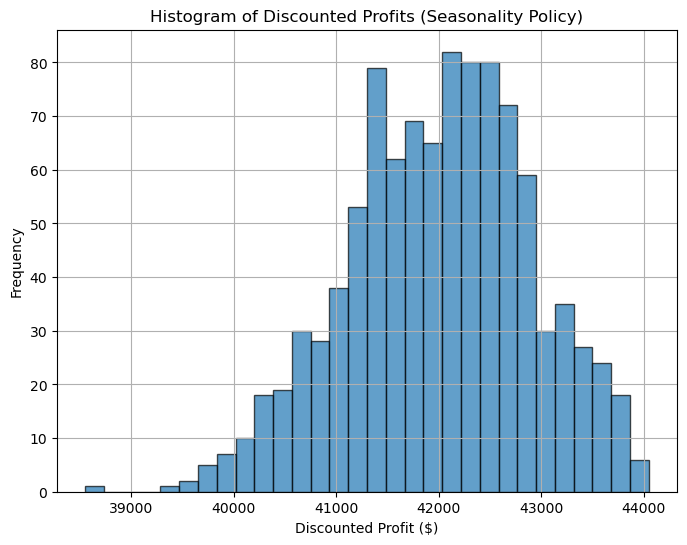

Simulation Results (Seasonality Policy):
Simulations run: 1000
Average Discounted Profit: $42008.03
Profit Volatility (Std Dev): $897.60
Coach Overbooking Frequency: 81.70%
Average Overbooking Cost: $1009.75
Average Bumped Up Passengers: 0.85
Average Bumped Off Passengers: 2.28


In [9]:
# --- Policy B: Seasonality Policy ---


(DP_season, policy_season, beta, T, C_max, F_max, 
 coach_options, first_options, p_increase, coach_capacity, first_capacity, 
 p_show_coach, p_show_first) = compute_dp_seasonality(overbook)

simulation_results_B = simulate_forward_seasonality(DP_season, policy_season, beta, T, C_max, F_max, 
                                                    coach_options, first_options, p_increase, 
                                                    coach_capacity, first_capacity, 
                                                    p_show_coach, p_show_first, num_simulations)

Columns in df_A: Index(['coach_sold', 'first_sold', 'coach_show', 'first_show', 'revenue',
       'over_cost', 'total_profit'],
      dtype='object')
Columns in df_B: Index(['coach_sold', 'first_sold', 'coach_show', 'first_show', 'revenue',
       'over_cost', 'total_profit', 'bumped_off', 'bumped_up'],
      dtype='object')


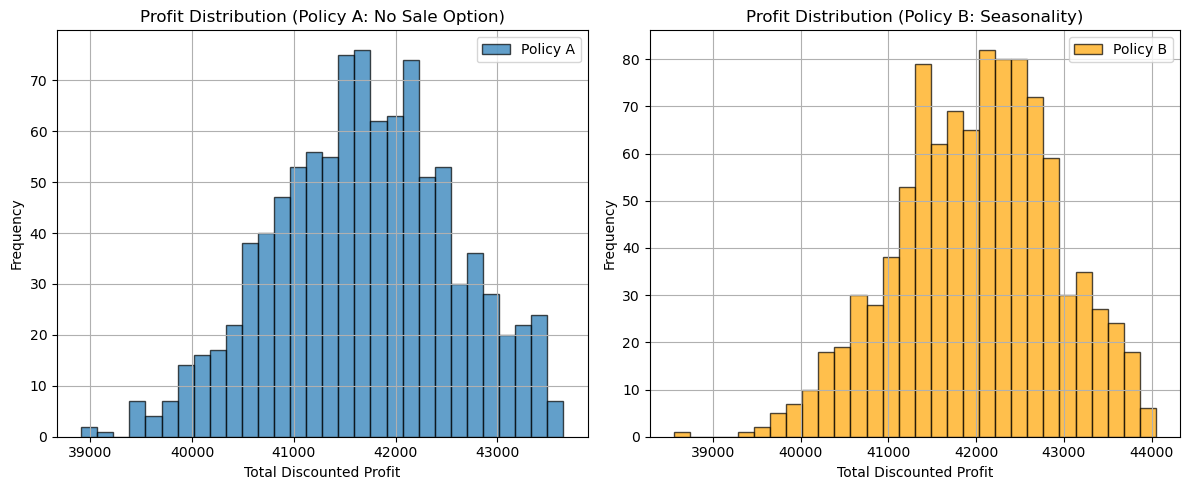

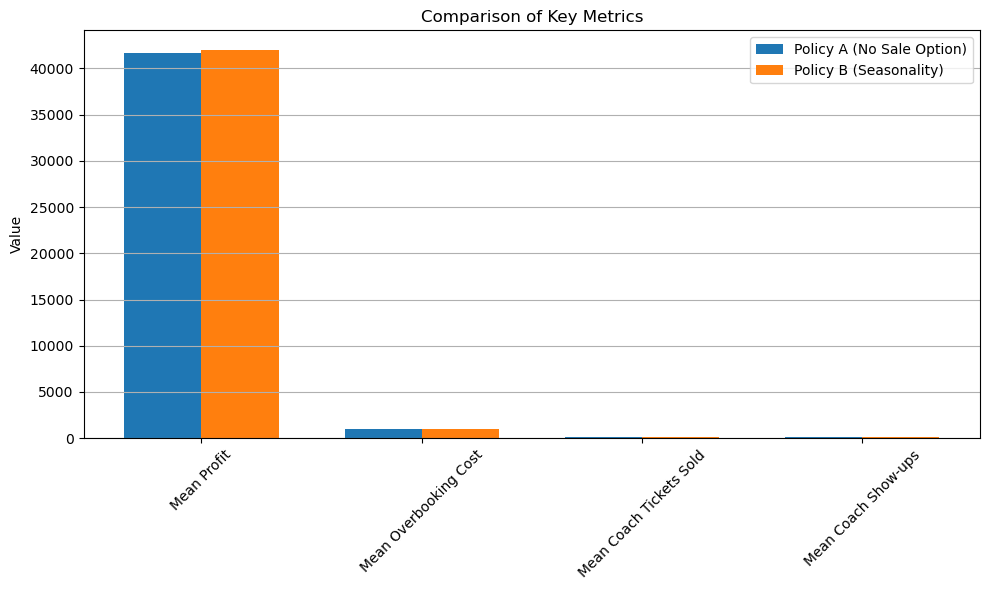

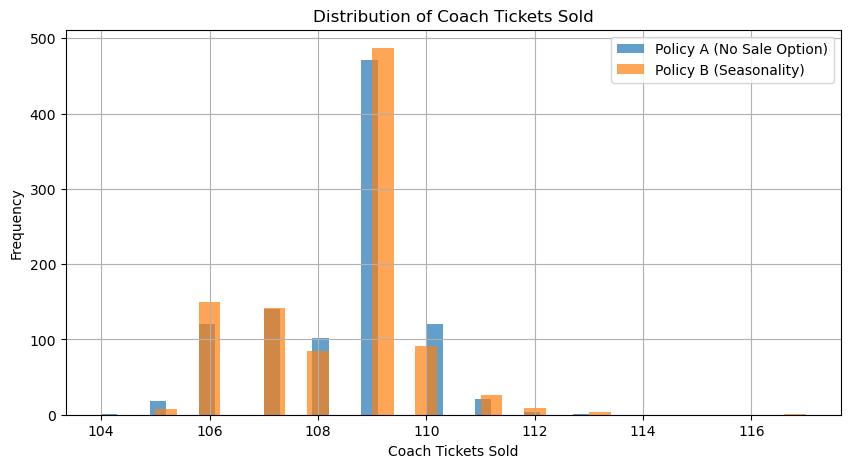

In [24]:
# Create DataFrames from simulation results.
df_A = pd.DataFrame(simulation_results_A)
df_B = pd.DataFrame(simulation_results_B)

# Check the available columns in your DataFrames.
print("Columns in df_A:", df_A.columns)
print("Columns in df_B:", df_B.columns)

# Define metrics and corresponding labels.
metrics = ['total_profit', 'over_cost', 'coach_sold', 'coach_show']
labels = ['Mean Profit', 'Mean Overbooking Cost', 'Mean Coach Tickets Sold', 'Mean Coach Show-ups']

# Compute the mean for each metric from both DataFrames.
values_A = [df_A[metric].mean() for metric in metrics]
values_B = [df_B[metric].mean() for metric in metrics]

# ----------------------------
# Visualization 1: Histograms of Total Discounted Profits
# ----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_A["total_profit"], bins=30, edgecolor='black', alpha=0.7, label="Policy A")
plt.xlabel("Total Discounted Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution (Policy A: No Sale Option)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df_B["total_profit"], bins=30, edgecolor='black', alpha=0.7, color="orange", label="Policy B")
plt.xlabel("Total Discounted Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution (Policy B: Seasonality)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ----------------------------
# Visualization 2: Bar Chart Comparing Key Metrics
# ----------------------------
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, values_A, width, label="Policy A (No Sale Option)")
plt.bar(x + width/2, values_B, width, label="Policy B (Seasonality)")
plt.xticks(x, labels, rotation=45)
plt.ylabel("Value")
plt.title("Comparison of Key Metrics")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# ----------------------------
# Visualization 3: Distribution of Coach Tickets Sold
# ----------------------------
plt.figure(figsize=(10, 5))
plt.hist(df_A["coach_sold"], bins=30, alpha=0.7, label="Policy A (No Sale Option)")
plt.hist(df_B["coach_sold"], bins=30, alpha=0.7, label="Policy B (Seasonality)")
plt.xlabel("Coach Tickets Sold")
plt.ylabel("Frequency")
plt.title("Distribution of Coach Tickets Sold")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# Create DataFrames from your simulation results.
df_A = pd.DataFrame(simulation_results_A)  # Policy A: No Sale Option
df_B = pd.DataFrame(simulation_results_B)  # Policy B: Seasonality

# For debugging, print the available columns.
print("Columns in Policy A DF:", df_A.columns)
print("Columns in Policy B DF:", df_B.columns)

# ----------------------------
# Compute Key Performance Indicators (KPIs)
# ----------------------------
# Define the KPIs you want to display. Adjust the lambda functions if needed.
metrics = {
    "Avg Profit": lambda df: df["total_profit"].mean(),
    "Avg Overbooking Cost": lambda df: df["over_cost"].mean(),
    "Avg Coach Sold": lambda df: df["coach_sold"].mean(),
    "Avg Coach Show-ups": lambda df: df["coach_show"].mean(),
    "Avg First Sold": lambda df: df["first_sold"].mean(),
    "Avg First Show-ups": lambda df: df["first_show"].mean()
}

# Compute KPI values for each policy.
kpi_A = {key: func(df_A) for key, func in metrics.items()}
kpi_B = {key: func(df_B) for key, func in metrics.items()}

# Create a DataFrame for easier plotting.
df_kpi = pd.DataFrame({
    "Metric": list(metrics.keys()),
    "Policy A (No Sale)": list(kpi_A.values()),
    "Policy B (Seasonality)": list(kpi_B.values())
})
print(df_kpi)




Columns in Policy A DF: Index(['coach_sold', 'first_sold', 'coach_show', 'first_show', 'revenue',
       'over_cost', 'total_profit'],
      dtype='object')
Columns in Policy B DF: Index(['coach_sold', 'first_sold', 'coach_show', 'first_show', 'revenue',
       'over_cost', 'total_profit', 'bumped_off', 'bumped_up'],
      dtype='object')
                 Metric  Policy A (No Sale)  Policy B (Seasonality)
0            Avg Profit        41683.303761             42008.02603
1  Avg Overbooking Cost         1040.375000              1009.75000
2        Avg Coach Sold          108.352000               108.34400
3    Avg Coach Show-ups          102.951000               102.90800
4        Avg First Sold           19.607000                19.54700
5    Avg First Show-ups           19.040000                18.91800


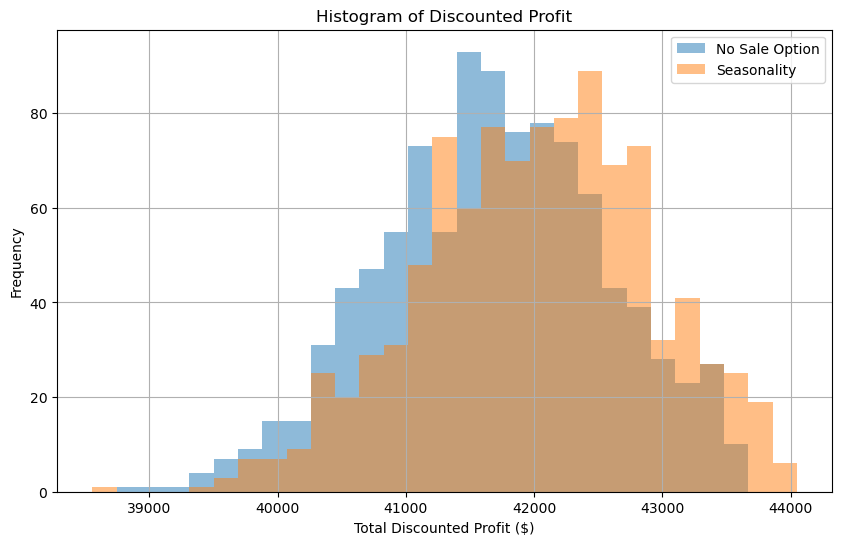

In [31]:
# Create DataFrames from the simulation results.
df_A = pd.DataFrame(simulation_results_A)  # No Sale Option Policy
df_A["policy"] = "No Sale Option"
df_B = pd.DataFrame(simulation_results_B)  # Seasonality Policy
df_B["policy"] = "Seasonality"

# Combine the two DataFrames for comparison.
df_all = pd.concat([df_A, df_B], ignore_index=True)

# Optional: Create an overlapping histogram for discounted profit distributions.
plt.figure(figsize=(10,6))
bins = np.linspace(df_all["total_profit"].min(), df_all["total_profit"].max(), 30)
plt.hist(df_A["total_profit"], bins=bins, alpha=0.5, label="No Sale Option")
plt.hist(df_B["total_profit"], bins=bins, alpha=0.5, label="Seasonality")
plt.xlabel("Total Discounted Profit ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Discounted Profit")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()